In [2]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import inception_v3
import os
import torch.nn.functional as F
import matplotlib.cm as cm
import cv2

In [4]:
Iv3 = inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\york/.cache\torch\hub\checkpoints\inception_v3_google-1a9a5a14.pth


In [6]:
next(iter(Iv3.named_modules()))

('',
 Inception3(
   (Conv2d_1a_3x3): BasicConv2d(
     (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_2a_3x3): BasicConv2d(
     (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_2b_3x3): BasicConv2d(
     (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (Conv2d_3b_1x1): BasicConv2d(
     (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
   )
   (Conv2d_4a_3x3): BasicConv2d(
     (conv): Conv2d(80, 192,

In [10]:
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_in_ft1 = Iv3.AuxLogits.fc.in_features
Iv3.AuxLogits.fc = nn.Linear(num_in_ft1, num_classes)

num_in_ft2 = Iv3.fc.in_features
Iv3.fc = nn.Linear(num_in_ft2, num_classes) 

Iv3.to(device)

Iv3.load_state_dict(torch.load(os.path.join(os.getcwd(),'model','Iv3_3')))

<All keys matched successfully>

In [50]:
class GradCAM(object):
    """
    1: 网络不更新梯度,输入需要梯度更新
    2: 使用目标类别的得分做反向传播
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple,长度为1
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()

    def __call__(self, inputs, index):
        """
        :param inputs: [1,3,H,W]
        :param index: class id
        :return:
        """
        self.net.zero_grad()
        output = self.net(inputs)  # [1,num_classes]
        if index is None:
            index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))  # [C]

        feature = self.feature[0].cpu().data.numpy()  # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        cam = np.maximum(cam, 0)  # ReLU

        # 数值归一化
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        cam = cv2.resize(cam, (299, 299))
        return cam

In [37]:
def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # 将mask转为heatmap
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap)/255
    heatmap = heatmap[...,::-1] #gbr to rgb
    
    # 合并heatmap到原始图像
    cam = heatmap + np.float32(image)
    return norm_image(cam), (heatmap*255).astype(np.uint8)

In [36]:
def norm_image(image):
    image = image.copy()
    image -= np.max(np.min(image),0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

In [11]:
def get_last_conv_name(net):
    
    layer_name=None
    for name, m in net.named_modules():
        if isinstance(m, nn.Conv2d):
            layer_name=name
    return layer_name

In [12]:
get_last_conv_name(Iv3)

'Mixed_7c.branch_pool.conv'

In [13]:
Iv3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [22]:
import cv2
from PIL import Image

In [27]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image succesfully loaded")
    return image

def normalize(image, transform):
    image = transform(image)
    image = image.cuda()
    image = image.unsqueeze(0)
    image.requires_grad=True
    return image

In [51]:
input_size=299

test_transform = transforms.Compose([
    transforms.Resize((input_size,input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
]) 

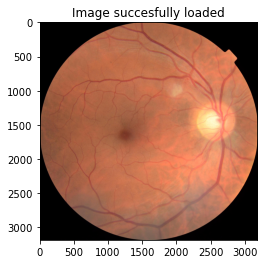

In [52]:
diabete_1 = load_image(r"C:\Users\york\multi-eye-disease-detection\diabetes\1 (148).jpeg")
diabete_1_normal = normalize(diabete_1, test_transform)

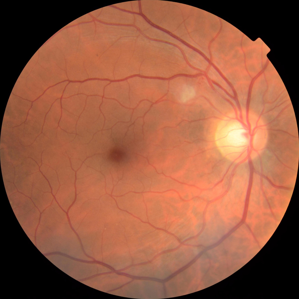

In [45]:
diabete_1.resize((299,299))

In [53]:
diabete_1_normal.shape

torch.Size([1, 3, 299, 299])

In [79]:
# 输出图像
image_dict = {}
layer_name = get_last_conv_name(Iv3)
grad_cam = GradCAM(Iv3,'Mixed_7c.branch3x3_1.conv')

In [80]:
mask = grad_cam(diabete_1_normal, 1)

feature shape:torch.Size([1, 384, 8, 8])
feature shape:torch.Size([1, 448, 8, 8])
feature shape:torch.Size([1, 384, 8, 8])
feature shape:torch.Size([1, 192, 8, 8])
feature shape:torch.Size([1, 192, 8, 8])


In [81]:
image_dict['cam'], image_dict['heatmap'] = gen_cam(diabete_1.resize((299,299)), mask)

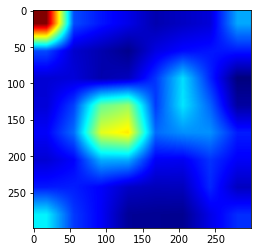

In [82]:
plt.imshow(image_dict['heatmap'])